In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ebayplacement/DataSet-TweetsEbay.csv
/kaggle/input/glovetwitter100d/glove.twitter.27B.100d.txt


In [2]:
pip install mglearn

     |████████████████████████████████| 540 kB 835 kB/s eta 0:00:01
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=384f25e316386bd54eebacad5aa8759b62ad23532c2b4c13ed815675247af963
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import mglearn
import matplotlib.pyplot as plt
import nltk                                         #Natural language processing tool-kit
import string
from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from gensim.models import Word2Vec                                   #For Word2Vec
from collections import defaultdict
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm
from nltk import word_tokenize

In [4]:
tweet_df =pd.read_csv('../input/ebayplacement/DataSet-TweetsEbay.csv',encoding='utf-8')
tweet_df.head()

,timestamp,tweet_text,sentiment,eBay/customer,category,likes,retweets,username,all_hashtags,followers_count
0,18-06-2020 23:56,"b""@AskeBay I purchased an item from one of you...",-1,Customer,NaN,0,0,b'CKidsTales',[],1248
1,18-06-2020 23:45,b'@AskeBay your feedback system is fucked up f...,-1,Customer,NaN,0,0,b'gibbychea',[],1201
2,18-06-2020 23:43,b'What so hard about leaving a good feedback o...,-1,Customer,NaN,2,0,b'gibbychea',[],1201
3,18-06-2020 23:41,b'@AskeBay @funtimegarry Here? https://t.co/NB...,0,Customer,NaN,0,0,b'Parlenicjj',[],150
4,18-06-2020 23:38,b'@AskeBay @AskeBay @GDPRbreaches How can I lo...,-1,Customer,NaN,0,0,b'CSMEugene',[],95


In [5]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12008 entries, 0 to 12007
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        12008 non-null  object
 1   tweet_text       12008 non-null  object
 2   sentiment        12008 non-null  int64 
 3   eBay/customer    12008 non-null  object
 4   category         3273 non-null   object
 5   likes            12008 non-null  int64 
 6   retweets         12008 non-null  int64 
 7   username         12008 non-null  object
 8   all_hashtags     12008 non-null  object
 9   followers_count  12008 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 938.2+ KB


Understanding Data

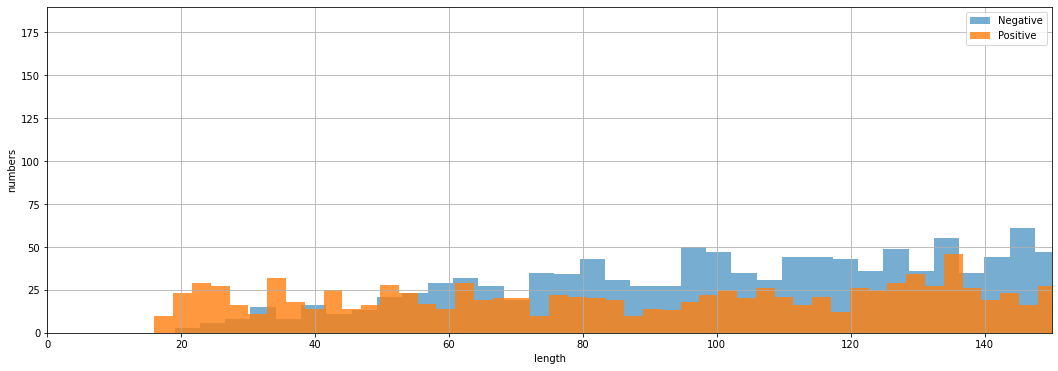

In [6]:
def length(text):    
    return len(text)

tweet_df['length'] = tweet_df['tweet_text'].apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(tweet_df[tweet_df['sentiment'] == -1]['length'], alpha = 0.6, bins=bins, label='Negative')
plt.hist(tweet_df[tweet_df['sentiment'] == 1]['length'], alpha = 0.8, bins=bins, label='Positive')
#plt.hist(tweet_df[tweet_df['sentiment'] == 0]['length'], alpha = 0.8, bins=bins, label='Neutral')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

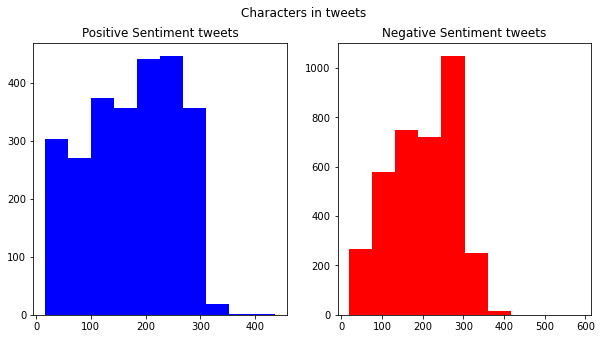

In [7]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet_df[tweet_df['sentiment']==1]['tweet_text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('Positive Sentiment tweets')
tweet_len=tweet_df[tweet_df['sentiment']==-1]['tweet_text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Negative Sentiment tweets')
fig.suptitle('Characters in tweets')
plt.show()

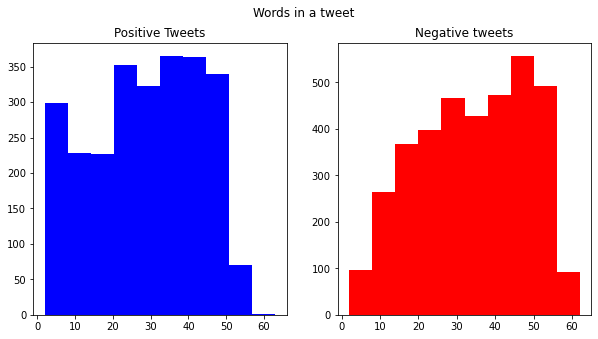

In [8]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet_df[tweet_df['sentiment']==1]['tweet_text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('Positive Tweets')
tweet_len=tweet_df[tweet_df['sentiment']==-1]['tweet_text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='red')
ax2.set_title('Negative tweets')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

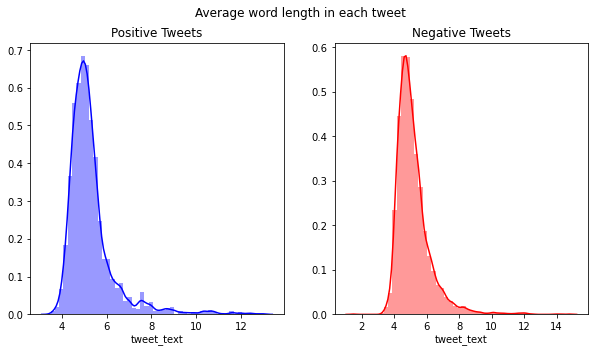

In [9]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=tweet_df[tweet_df['sentiment']==1]['tweet_text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title('Positive Tweets')
word=tweet_df[tweet_df['sentiment']==-1]['tweet_text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title('Negative Tweets')
fig.suptitle('Average word length in each tweet')

In [10]:
stop=set(stopwords.words('english'))


In [11]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet_df[tweet_df['sentiment']==target]['tweet_text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in tweet_df[tweet_df['sentiment']==target]['tweet_text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [12]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

In [13]:
np.array(stop)

array({'mustn', 'of', 'theirs', 'too', 'are', 'the', 'into', "you'd", 'against', "wouldn't", 'there', "needn't", 'nor', 'i', 'or', "hadn't", 'so', 'she', 'it', 'about', 'such', 'ain', 'aren', 'only', 'for', 'some', 'ourselves', 'until', 'as', 'its', 'isn', 'over', 'before', 'we', 'does', "weren't", 'hadn', 'once', 'few', 'doesn', 'same', 'will', "that'll", 'now', 'me', 't', 'wouldn', 'while', 'your', 'those', 'on', 'no', 'herself', 'through', 'had', 'whom', 'then', 'a', 'can', 'how', 'hers', 'needn', "you'll", 'was', 'doing', 'to', "doesn't", "won't", 'and', 'when', 'from', 'don', 'am', 'couldn', "she's", 've', 'haven', 'myself', 'by', 'did', 'has', 'll', 'hasn', "it's", 'between', 'more', 'because', 'than', 'why', 'ma', 'down', 'out', 'didn', "mightn't", 'm', 'these', 'under', 'shouldn', 'off', 'having', 'who', 'that', 'own', 'being', 'this', 'itself', 'he', 's', 'my', "aren't", "hasn't", 'him', 'again', 'them', 're', "shouldn't", "haven't", 'themselves', 'any', 'ours', 'yourselves', 

<BarContainer object of 10 artists>

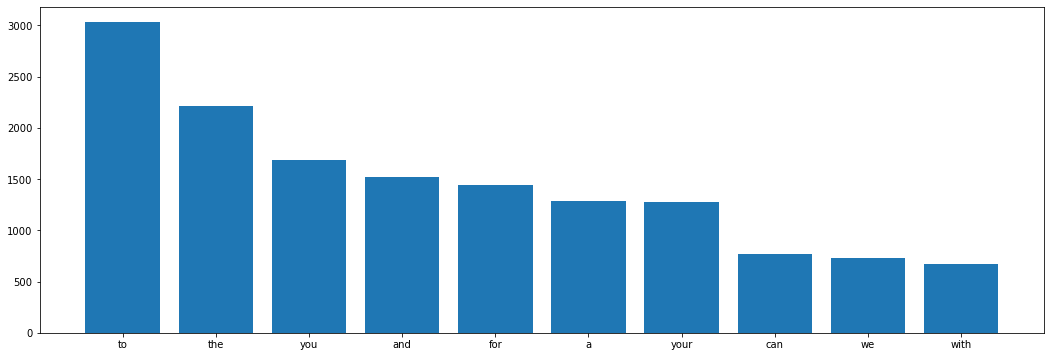

In [14]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 17 artists>

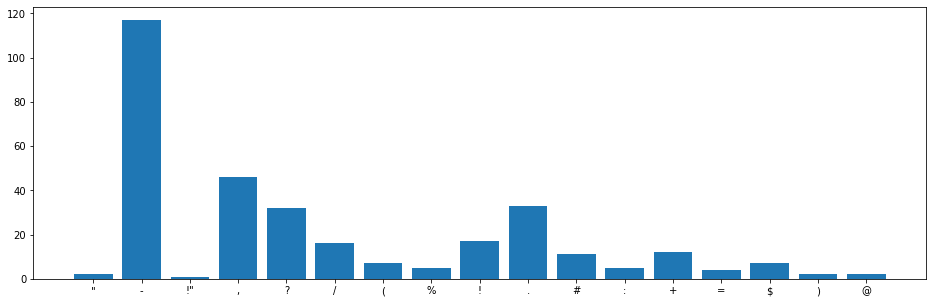

In [15]:
import string
plt.figure(figsize=(16,5))
corpus=create_corpus(-1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 14 artists>

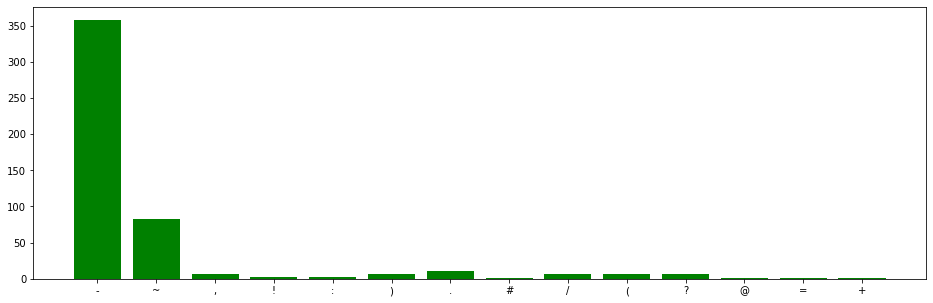

In [16]:
plt.figure(figsize=(16,5))
corpus=create_corpus(1)
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

In [17]:
plt.figure(figsize=(16,5))
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<Figure size 1152x360 with 0 Axes>

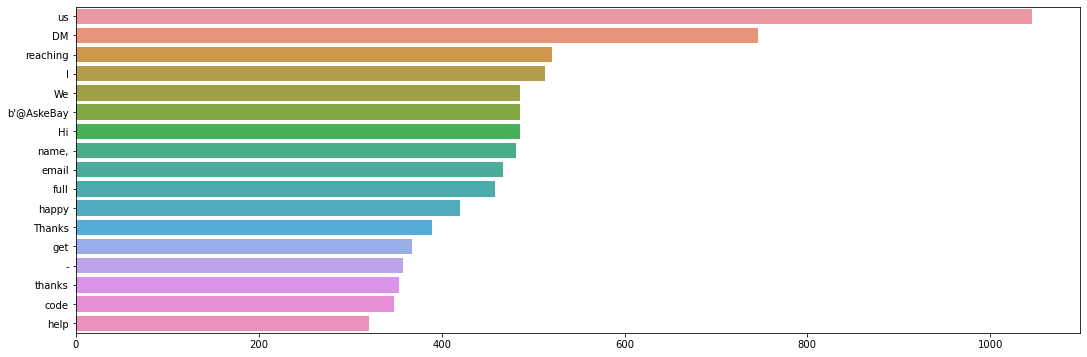

In [18]:
sns.barplot(x=y,y=x)

N-gram analysis

In [19]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

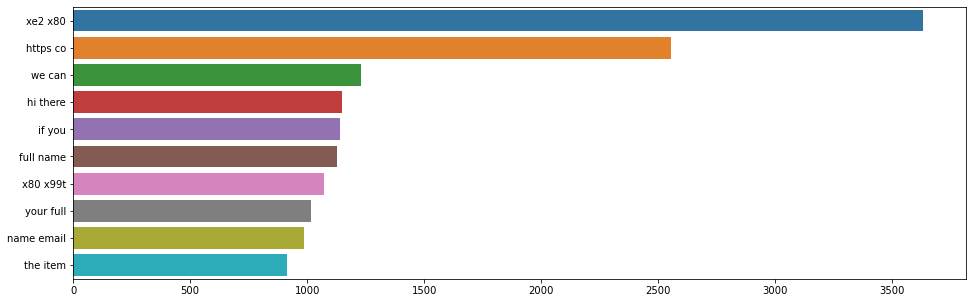

In [20]:
plt.figure(figsize=(16,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet_df['tweet_text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

Data Cleaning

In [21]:
import re
text = "b'@weston777 Thanks! ~Laura https://t.co/KlP3BGeZjr'"
text_relink = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

In [22]:
# tweet_df['tweet_text'] = tweet_df['tweet_text'].map(lambda x: re.sub("([@])\w+", '', x))  # remove ...words with @Askebay
# tweet_df['tweet_text'] = tweet_df['tweet_text'].map(lambda x: re.sub("[\'\"@]", '', x))  # remove ...words with @Askebay
# tweet_df['tweet_text'] = tweet_df['tweet_text'].map(lambda x: re.sub('[''"",\.!?]', '', x)) # remove ,.!?
# tweet_df['tweet_text'] = tweet_df['tweet_text'].map(lambda x: re.sub('#[A-Za-z0-9]+', '', x))  # remove hashtag
# tweet_df['tweet_text'] = tweet_df['tweet_text'].map(lambda x: re.sub('https://tco/[A-Za-z0-9]+', '', x))  # remove link
# tweet_df['tweet_text'] = tweet_df['tweet_text'].map(lambda x: re.sub('https://t.co/[A-Za-z0-9]+', '', x))  # remove link


Data Cleaning Functions

In [23]:
contractions = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"i'd": "I would",
"i'd've": "I would have",
"i'll": "I will",
"i'll've": "I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "yyou would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

added_stopwords = {"xe2":"","xe80":"","x99s":""}

In [24]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_b(text):
    if text[0:1] == 'b':
        text = text[1:]
    return text

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

def remove_contractions(text):
    for word in text.split():
        if word.lower() in contractions: ## refer the previous cell for contractions info
            text = text.replace(word, contractions[word.lower()])
    return text

def replace_num_with_token(text):
    pattern = re.compile(r"[0-9]+")
    return pattern.sub(r' <num> ', text)

def remove_hex_code(text):
    return re.sub(r'(\\x(.){2})', '',text)

In [25]:
tweet_df['tweet_text']=tweet_df['tweet_text'].apply(lambda x : remove_URL(x))
tweet_df['tweet_text']=tweet_df['tweet_text'].apply(lambda x : remove_html(x))
tweet_df['tweet_text']=tweet_df['tweet_text'].apply(lambda x: remove_emoji(x))
tweet_df['tweet_text']=tweet_df['tweet_text'].apply(lambda x: remove_b(x))
tweet_df['tweet_text']=tweet_df['tweet_text'].apply(lambda x : remove_punct(x))
tweet_df['tweet_text']=tweet_df['tweet_text'].apply(lambda x : remove_contractions(x))
tweet_df['tweet_text']=tweet_df['tweet_text'].apply(lambda x : remove_hex_code(x))
tweet_df['tweet_text']=tweet_df['tweet_text'].apply(lambda x : replace_num_with_token(x))

In [26]:
from nltk.corpus import stopwords


def create_corpus(df):
    corpus=[]
    for tweet in tqdm(tweet_df["tweet_text"]):
        text = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha()==True) & (word not in stop))]
        corpus.append(text)
    return corpus

In [27]:
tweet_df['tweet_text']

0        AskeBay I purchased an item from one of your s...
1        AskeBay your feedback system is fucked up for ...
2        What so hard about leaving a good feedback on ...
3                               AskeBay funtimegarry Here 
4        AskeBay AskeBay GDPRbreaches How can I log a c...
                               ...                        
12003    AskeBay I have nearly daily ebay does not need...
12004    I have  <num>  orders where buyers are contact...
12005    AskeBay hello me again Another ebay buyer is b...
12006    AskeBay Hi there I just recently started and s...
12007    AskeBay Its clear an auction I did with a inte...
Name: tweet_text, Length: 12008, dtype: object

In [28]:
corpus_new1=create_corpus_df(tweet_df,1)
len(corpus_new1)
corpus_new1[:5]


['mendersby', '<num>', 'AskeBay', 'Thanks', 'for']

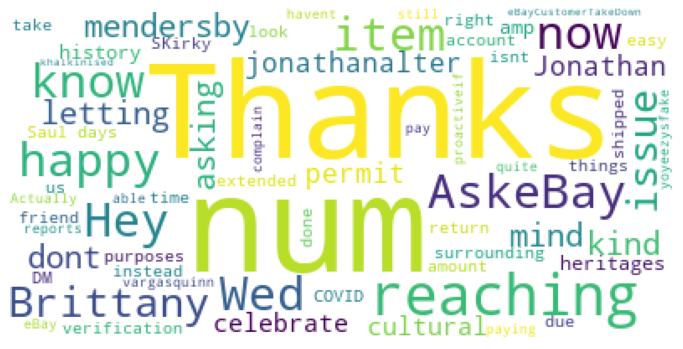

In [29]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:150]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [30]:
corpus_new2=create_corpus_df(tweet_df,-1)
len(corpus_new2)
corpus_new2[:5]

['AskeBay', 'I', 'purchased', 'an', 'item']

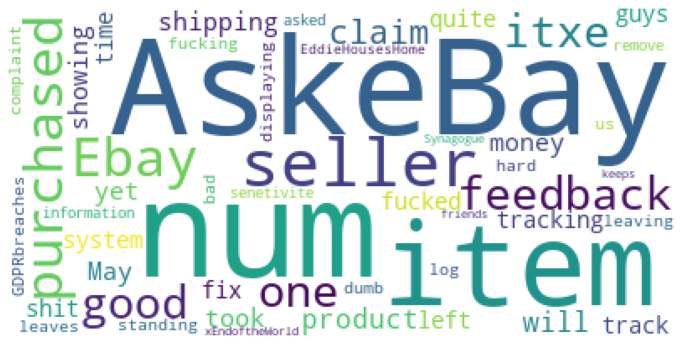

In [31]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='white',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new2[:150]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

Embedding

In [32]:
embedding_dict ={}
with open('../input/glovetwitter100d/glove.twitter.27B.100d.txt','r') as f:
    for line in f:
#         print(line)
        values= line.split()
        word = values[0]
        vector= np.asarray(values[1:], "float32")
        embedding_dict[word] = vector
f.close()

In [33]:
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df["tweet_text"]):
        text = [word.lower() for word in word_tokenize(tweet) if ((word.isalpha()==True) & (word not in stop))]
        corpus.append(text)
    return corpus

In [34]:
corpus = create_corpus(tweet_df)

100%|██████████| 12008/12008 [00:04<00:00, 2681.79it/s]


In [35]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_LEN=150
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [ ]:
word_index = tokenizer_obj.word_index
num_words = len(word_index) + 1
emb_matrix = np.zeros(shape = (num_words, 100))

for word, i in word_index.items():
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        emb_matrix[i] = emb_vec
    else:
        print("the vec for {} is not there". format(word))

In [37]:
from keras import Sequential
from keras.layers  import Embedding, SpatialDropout1D, LSTM, Dense
from keras.initializers import Constant
from keras.optimizers import Adam
model = Sequential()

embedding = Embedding(input_dim = num_words, output_dim= 100, 
                      embeddings_initializer = Constant(emb_matrix), 
                      trainable=False, 
                      input_length = MAX_LEN)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.3))
model.add(Dense(3, activation='softmax'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 100)          1355000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 150, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 1,397,435
Trainable params: 42,435
Non-trainable params: 1,355,000
_________________________________________________________________


In [39]:
from sklearn.preprocessing import OneHotEncoder
final_train=tweet_pad

Y=[]
for val in tweet_df['sentiment']:
    if val==-1:
        Y.append([1,0,0])
    elif val==0:
        Y.append([0,1,0])
    else:
        Y.append([0,0,1])
Y = np.array(Y)   

In [40]:
### Formation of hold out validation set
from sklearn.model_selection import train_test_split


X_training,X_holdout_test,y_training,y_holdout_test=train_test_split(final_train,Y,test_size=0.15, stratify=tweet_df['sentiment'])

print("Shape of Holdout test set ",X_holdout_test.shape)

### Formation of training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training,test_size=0.15, stratify=y_training)

print("Shape of training set ",X_train.shape)
print("Shape of validationset ",X_val.shape)

Shape of Holdout test set  (1802, 150)
Shape of training set  (8675, 150)
Shape of validationset  (1531, 150)


In [41]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_val,y_val),verbose=1)

Epoch 1/15
2169/2169 [==============================] - 1099s 507ms/step - loss: 0.6220 - accuracy: 0.4832 - val_loss: 0.6074 - val_accuracy: 0.4840
Epoch 2/15
  12/2169 [..............................] - ETA: 16:44 - loss: 0.5731 - accuracy: 0.5625

KeyboardInterrupt: 